In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
#device = "cpu"
directory = os.getcwd()
directory = directory + '\\cats_photos'

plt_width = plt_height = 8
matplotlib.rcParams['figure.figsize'] = [plt_width, plt_height]

In [3]:
def get_data_loader(data_dir=directory, width=64, height=64, batch_size=128, train = True):
    """
    Define the way we compose the batch dataset including the augmentation for increasing the number of data
    and return the augmented batch-dataset
    :param data_dir: root directory where the either train or test dataset is
    :param batch_size: size of the batch
    :param train: true if current phase is training, else false
    :return: augmented batch dataset
    """

    # define how we augment the data for composing the batch-dataset in train and test step
    transform = {
        'train': transforms.Compose([
            transforms.Resize([width, height]), # Resizing the image as the VGG only take 224 x 244 as input size
            #transforms.RandomHorizontalFlip(), # Flip the data horizontally
            #TODO if it is needed, add the random crop
            transforms.ToTensor(),
            #transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
            #transforms.LinearTransformation(transformation_matrix=)
        ]),
        'test': transforms.Compose([
            transforms.Resize([width, height]),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            #transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])
    }

    # ImageFloder with root directory and defined transformation methods for batch as well as data augmentation
    data = torchvision.datasets.ImageFolder(root=data_dir, transform=transform['train'] if train else 'test')
    data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=4)

    return data_loader

In [4]:
torch.multiprocessing.freeze_support()
data_dir=directory
width=height=16
batch_size=256
data_loader = get_data_loader(data_dir=directory, width=width, height=height, batch_size=batch_size)

batch_x, batch_y = next(iter(data_loader))
batch_size, channels_size, width, height = np.shape(batch_x)

In [5]:
image_size = width * height
hidden_size = 1024
latent_dim = 64
epochs = 25

class VarationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VarationalAutoEncoder, self).__init__()
        self.fc1 = nn.Linear(image_size * channels_size, hidden_size)
        self.fc2_mean = nn.Linear(hidden_size, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_size, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_size)
        self.fc4 = nn.Linear(hidden_size, image_size * channels_size)
        
    def encode(self, x):
        x = x.view(batch_size, channels_size * image_size)
        h = F.relu(self.fc1(x))
        mu = self.fc2_mean(h)
        log_var = self.fc2_logvar(h)
        return mu, log_var
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = F.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h))
        return out
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

    
class VarationalCnnAutoEncoder(nn.Module):
    def __init__(self):
        super(VarationalCnnAutoEncoder, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, padding=3)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(image_size * 32, hidden_size)
        self.fc2_mean = nn.Linear(hidden_size, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_size, latent_dim)
        
        self.fc3 = nn.Linear(latent_dim, hidden_size)
        self.fc4 = nn.Linear(hidden_size, image_size * channels_size)
        
    def encode(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = x.view(batch_size, image_size * 32)
        h = F.relu(self.fc1(x))
        mu = self.fc2_mean(h)
        log_var = self.fc2_logvar(h)
        return mu, log_var
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = F.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h))
        return out
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

    
    
model = VarationalCnnAutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [6]:
def plot_images(images):
    if len(images) == 2:
        image = images[0]
        image = np.swapaxes(image, 0,1)
        image = np.swapaxes(image, 1,2)
        reconstructed = images[1]
        reconstructed = np.swapaxes(reconstructed, 0,1)
        reconstructed = np.swapaxes(reconstructed, 1,2)

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Original')

        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed)
        plt.title('Reconstructed')
    
    else:
        for idx, image in enumerate(images):
            image = np.swapaxes(image, 0,1)
            image = np.swapaxes(image, 1,2)
            plt.subplot(1, len(images), idx+1)
            plt.imshow(image)
            plt.title('Generated')
        
    plt.show()
    
    
def loss_function(reconstructed_image, original_image, mu, logvar):
    bce = F.binary_cross_entropy(reconstructed_image, 
                             original_image.view(batch_size, channels_size * image_size), reduction = 'sum')
    #bce = F.mse_loss(reconstructed_image, 
    #                             original_image.view(batch_size, channels_size, image_size))
    #kld = torch.sum(0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar, 1))
    kld = 0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar)
    return bce + kld


def train(model, epoch):
    train_loss = 0
    print_every = 100
    model.train()
    epoch_loss = 0
    for idx, (images, label) in enumerate(data_loader):
        if idx == len(data_loader) -1:
            continue
            
        images = images.to(device)
        
        reconstructed, mu, logvar = model(images)
        loss = loss_function(reconstructed, images, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        epoch_loss += loss.item()
        optimizer.step()
        
        if (idx) % print_every == 0:
            print("Train Epoch {} [Batch {}/{}]\tLoss: {:.3f}"
                  .format(epoch, idx, len(data_loader), train_loss/((idx+1) * batch_size) ))
            
            original = images[0].to("cpu")
            original = original.view(channels_size, width, height).detach().numpy()
            
            re_img = reconstructed[0].to("cpu")
            re_img = re_img.view(channels_size, width, height).detach().numpy()
            
            plot_images(images=[original, re_img])
            train_loss = 0
            
    print("===> Epoch {}, Average loss: {:.3f}".format(epoch, epoch_loss/len(data_loader.dataset)))
    

Train Epoch 0 [Batch 0/40]	Loss: 537.574


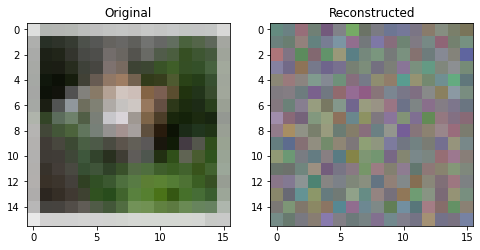

===> Epoch 0, Average loss: 507.819
Train Epoch 1 [Batch 0/40]	Loss: 493.799


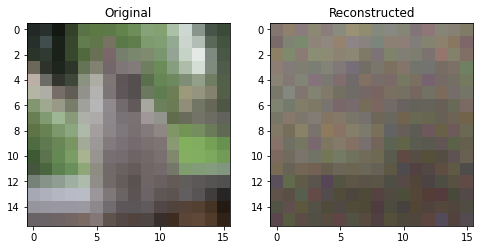

===> Epoch 1, Average loss: 485.507
Train Epoch 2 [Batch 0/40]	Loss: 478.532


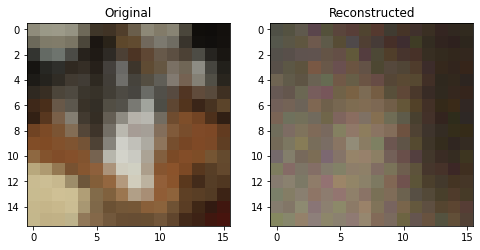

===> Epoch 2, Average loss: 478.650
Train Epoch 3 [Batch 0/40]	Loss: 472.828


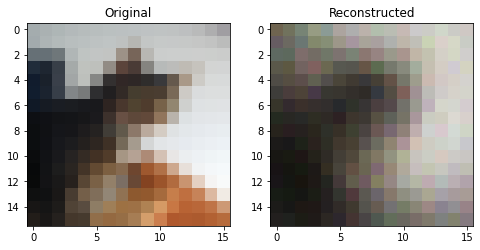

===> Epoch 3, Average loss: 474.346
Train Epoch 4 [Batch 0/40]	Loss: 475.701


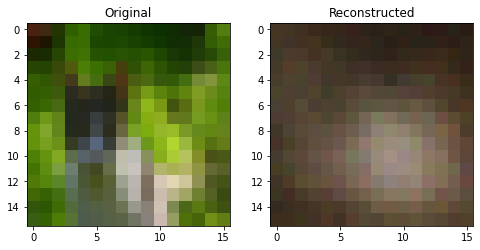

===> Epoch 4, Average loss: 471.658
Train Epoch 5 [Batch 0/40]	Loss: 470.164


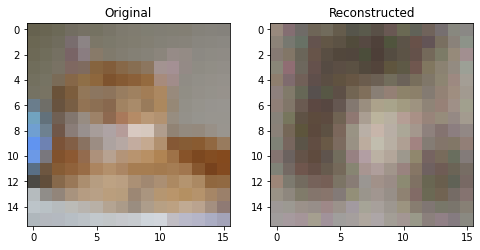

===> Epoch 5, Average loss: 469.395
Train Epoch 6 [Batch 0/40]	Loss: 471.215


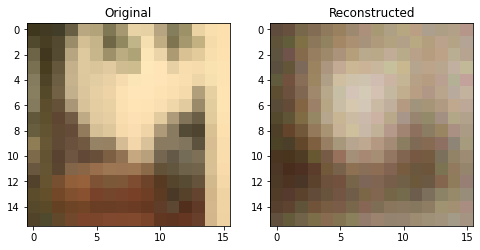

===> Epoch 6, Average loss: 468.118
Train Epoch 7 [Batch 0/40]	Loss: 471.527


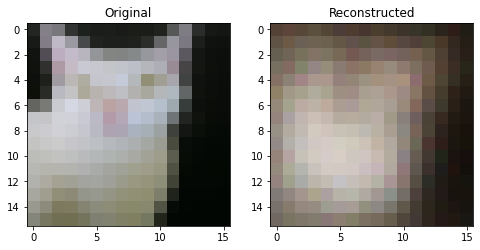

===> Epoch 7, Average loss: 467.219
Train Epoch 8 [Batch 0/40]	Loss: 462.292


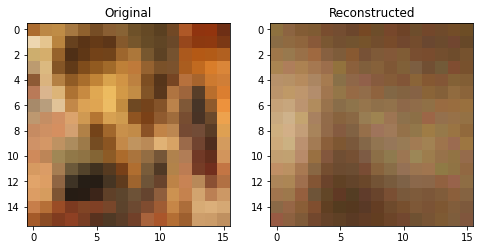

===> Epoch 8, Average loss: 466.697
Train Epoch 9 [Batch 0/40]	Loss: 462.199


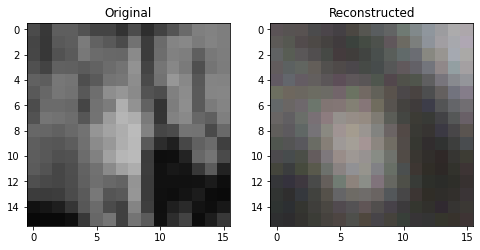

===> Epoch 9, Average loss: 466.066
Train Epoch 10 [Batch 0/40]	Loss: 465.744


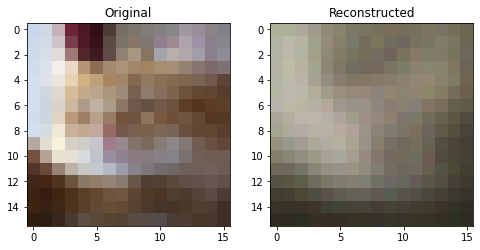

===> Epoch 10, Average loss: 465.501
Train Epoch 11 [Batch 0/40]	Loss: 467.282


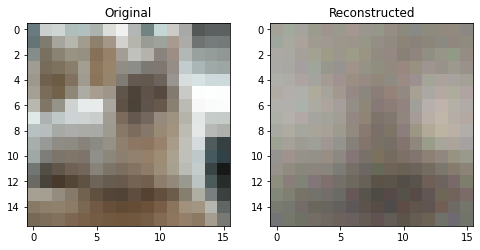

===> Epoch 11, Average loss: 465.075
Train Epoch 12 [Batch 0/40]	Loss: 462.050


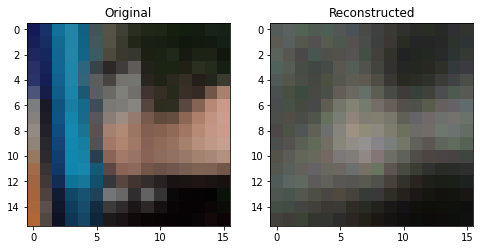

===> Epoch 12, Average loss: 464.903
Train Epoch 13 [Batch 0/40]	Loss: 470.864


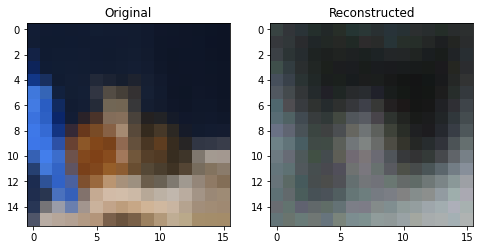

===> Epoch 13, Average loss: 464.832
Train Epoch 14 [Batch 0/40]	Loss: 470.606


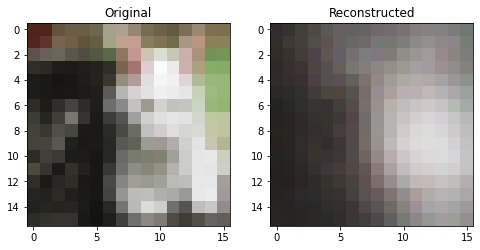

===> Epoch 14, Average loss: 464.722
Train Epoch 15 [Batch 0/40]	Loss: 465.253


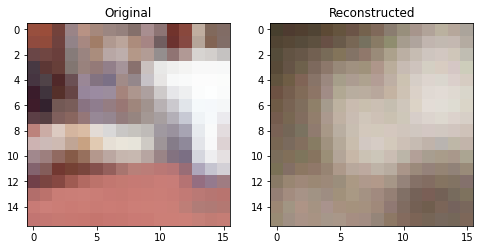

===> Epoch 15, Average loss: 464.593
Train Epoch 16 [Batch 0/40]	Loss: 462.231


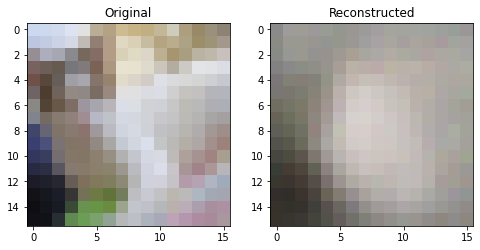

===> Epoch 16, Average loss: 464.544
Train Epoch 17 [Batch 0/40]	Loss: 463.870


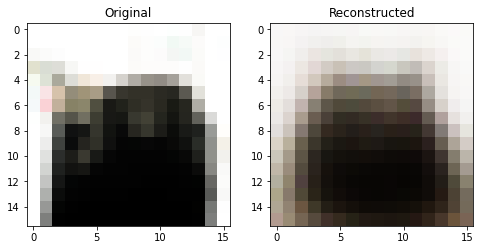

===> Epoch 17, Average loss: 464.295
Train Epoch 18 [Batch 0/40]	Loss: 461.913


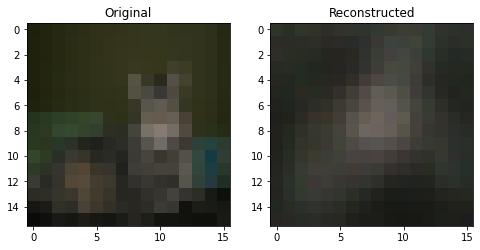

===> Epoch 18, Average loss: 464.155
Train Epoch 19 [Batch 0/40]	Loss: 467.574


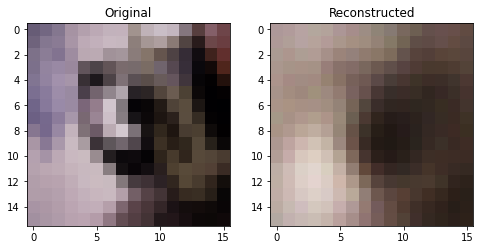

===> Epoch 19, Average loss: 464.103
Train Epoch 20 [Batch 0/40]	Loss: 467.111


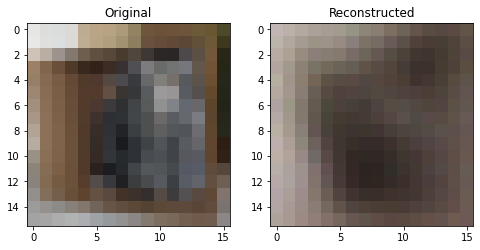

===> Epoch 20, Average loss: 464.095
Train Epoch 21 [Batch 0/40]	Loss: 461.613


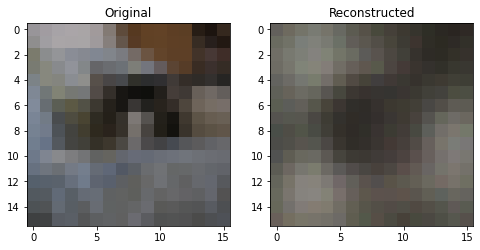

===> Epoch 21, Average loss: 464.029
Train Epoch 22 [Batch 0/40]	Loss: 465.488


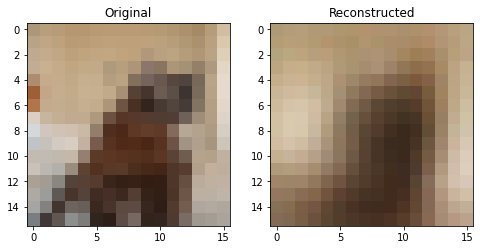

===> Epoch 22, Average loss: 464.088
Train Epoch 23 [Batch 0/40]	Loss: 463.935


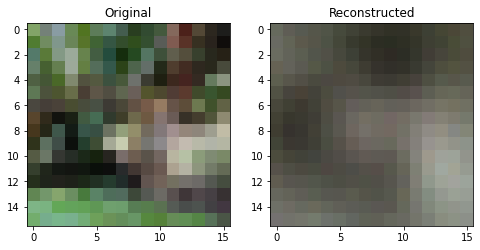

===> Epoch 23, Average loss: 463.825
Train Epoch 24 [Batch 0/40]	Loss: 466.668


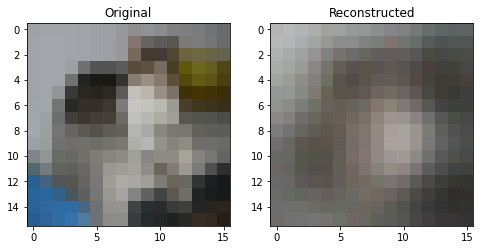

===> Epoch 24, Average loss: 463.826


In [7]:
for i in range(epochs):
    train(model=model, epoch=i)

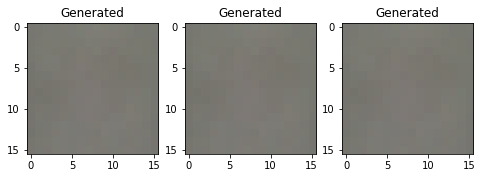

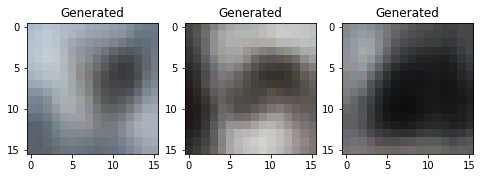

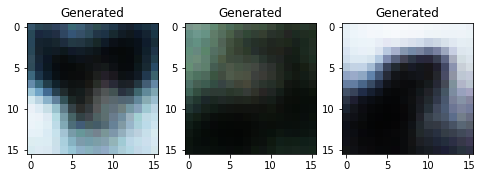

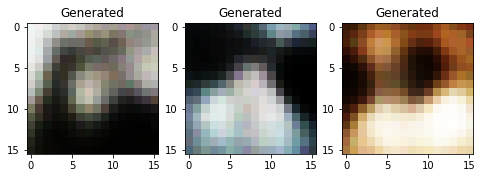

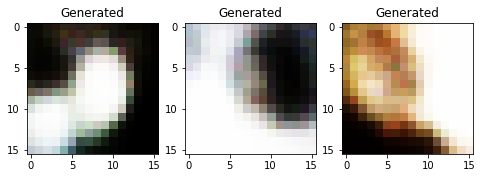

In [8]:
for i in range(5):
    images = []
    for j in range(3):
        z = (torch.randn(1,latent_dim) * i).to(device)
        latent = model.decode(z=z).cpu()
        image = latent.view(channels_size, width, height).detach().numpy() 
        images.append(image)
    plot_images(images=images) 